# CNN U-NET: Skull-Stripping em Imagens 2D

From: https://github.com/jocicmarko/ultrasound-nerve-segmentation

Exemplo de Skull-Stripping (Segmentação do cérebro) em imagens 2D de ressonância magnética utilizando a implementação da CNN U-NET do link acima. Os resultados iniciais desta implementação foram submetidos ao evento BRAINN 2017.

Neste exemplo utilizou-se as imagens do dataset CC-349, em que 250 imagens foram utilizadas para treino e como efeito ilustrativo, o teste foi realizado em 4 imagens as quais são apresentadas no fim do notebook.
         
CC-349 dataset: http://miclab.fee.unicamp.br/calgary-campinas-359 

Artigo U-NET: https://arxiv.org/pdf/1505.04597.pdf

Arquitetura da U-NET:
![](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

**Informações das pastas**:

```
src/
    train_mid_samples/ (imagens do treino em 2D da fatia central sagital) - Já criada, copiar para a pasta do notebook. 
    train_patches/ (patches para o treino) - Código irá criar!
    test_mid_samples/ (imagens do test em 2D da fatia central sagital) - Já criada, copiar para a pasta do notebook.
    test_patches/ (patches para o teste) Código irá criar!
    test_prep_data/ (dados de teste pré-processados para predição) - Código irá criar! 
    pred_data/ (resultados das predições da CNN) - Código irá criar!
    pred_image/ (imagens reconstruídas a partir das predições da CNN) - Código irá criar!

```


# Módulos a serem utilizados

In [1]:
%matplotlib inline
import numpy as np
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"    
import theano

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 2000.)


In [2]:
# Keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


Using Theano backend.


In [4]:
import glob
import time
import cv2
import matplotlib.pylab as plt
import sys
sys.path.append('../src')
from prep_ss_utils import create_data, save_2d_samples
from prep_ss_utils import sample_2d_patches, preprocess, get_mean_std_train, read_prep_test
from prep_ss_utils import load_train_data, reconstruct_2d_sample, save_data

As informações presentes nessa célula também estão no arquivo prepro_utils.py

In [40]:
# Diretório do notebook
out = '/home/adessowiki/Development/Oeslle/rnpi-notebooks/ss_data'

# Configurações da u-net
img_rows = 64
img_cols = 80
smooth = 1.
model_name = '30_epoch_unet.hdf5'

# Pastas que estão ou serão criadas no diretório do notebook
train_mid_samples = 'train_mid_samples'
train_patches = 'train_patches'
test_mid_samples = 'test_mid_samples'
test_patches = 'test_patches'
test_prep_data = 'test_prep_data'
pred_image = 'pred_image'
pred_data = 'pred_data'

# Função para criar novo diretório
def create_new_dir(dstDir):
    
    if not os.path.exists(dstDir):
        os.makedirs(dstDir)

# Pré-processamento

## Dados de Treino

In [36]:
if __name__ == '__main__':

    start_time = time.time()
    
    # Treino   
    print('-'*30)
    print('Creating Train 2D Patches...')
    print('-'*30)
    srcDir = os.path.join(out,train_mid_samples)
    dstDir = os.path.join(out,train_patches) 
    create_new_dir(dstDir)

    sample_2d_patches(srcDir, dstDir, 'train')
        
    print('-'*30)
    print('Creating Train Data...')
    print('-'*30)
    
    imgs, imgs_mask = create_data(dstDir)
    save_data(imgs, imgs_mask, os.path.join(out,'imgs_train.npy')
              , os.path.join(out,'imgs_mask_train.npy'),out)
    
    print("--- %s seconds ---" % (time.time() - start_time))

------------------------------
Creating Train 2D Patches...
------------------------------
Sampling Train Images ...
Saving train image patches: CAMP_SLE_CONTROL0002
Saving train image patches: CAMP_SLE_CONTROL0004
Saving train image patches: CAMP_SLE_CONTROL0006
Saving train image patches: CAMP_SLE_CONTROL0007
Saving train image patches: CAMP_SLE_CONTROL0008
Saving train image patches: CAMP_SLE_CONTROL0009
Saving train image patches: CAMP_SLE_CONTROL0015
Saving train image patches: CAMP_SLE_CONTROL0021
Saving train image patches: CAMP_SLE_CONTROL0022
Saving train image patches: CAMP_SLE_CONTROL0024
Saving train image patches: CAMP_SLE_CONTROL0027
Saving train image patches: CAMP_SLE_CONTROL0028
Saving train image patches: CAMP_SLE_CONTROL0029
Saving train image patches: CAMP_SLE_CONTROL0030
Saving train image patches: CAMP_SLE_CONTROL0031
Saving train image patches: CAMP_SLE_CONTROL0034
Saving train image patches: CAMP_SLE_CONTROL0036
Saving train image patches: CAMP_SLE_CONTROL0037
S

## Dados de Teste

In [37]:
if __name__ == '__main__':

    start_time = time.time()

    # Teste 
    print('-'*30)
    print('Creating Test 2D Patches...')
    print('-'*30)
    srcDir = os.path.join(out,test_mid_samples)
    dstDir = os.path.join(out,test_patches) 
    create_new_dir(dstDir)

    sample_2d_patches(srcDir, dstDir, 'test') # Criando patches para 4 imagens de teste

    print('-'*30)
    print('Creating Preprocessed Test Data...')
    print('-'*30)
    dstDir = os.path.join(out,'test_prep_data') 
    create_new_dir(dstDir)
    test_patches_folds = np.sort(glob.glob(os.path.join(out,test_patches +'/*')))
    mean, std = get_mean_std_train(os.path.join(out,'imgs_train.npy')
                                   , os.path.join(out,'imgs_mask_train.npy'))
       
    for fold in test_patches_folds:
        name = fold.split('/')[-1]
        print ("Image:", name)
        print ('\n')
        imgs, imgs_mask = create_data(fold)
        imgs_test = read_prep_test(imgs,mean,std)
        np.savez_compressed(os.path.join(dstDir,name +'-prep.npz'),
                            imgs_test = imgs_test)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    

------------------------------
Creating Test 2D Patches...
------------------------------
Sampling Test Images ...
Saving test image patches: CVCD10010001
/home/adessowiki/Development/Oeslle/rnpi-notebooks/ss_data/test_patches/CVCD10010001
Saving test image patches: CVCD10010002
/home/adessowiki/Development/Oeslle/rnpi-notebooks/ss_data/test_patches/CVCD10010002
Saving test image patches: CVCD10010003
/home/adessowiki/Development/Oeslle/rnpi-notebooks/ss_data/test_patches/CVCD10010003
Saving test image patches: CVCD10010004
/home/adessowiki/Development/Oeslle/rnpi-notebooks/ss_data/test_patches/CVCD10010004
------------------------------
Creating Preprocessed Test Data...
------------------------------
Image: CVCD10010001


Done: 0/34161 images
Done: 100/34161 images
Done: 200/34161 images
Done: 300/34161 images
Done: 400/34161 images
Done: 500/34161 images
Done: 600/34161 images
Done: 700/34161 images
Done: 800/34161 images
Done: 900/34161 images
Done: 1000/34161 images
Done: 1100/341

# Treinamento da CNN

In [23]:
def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)


def get_unet():
    
    inputs = Input((1, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

def run_train():
    
    print('-'*30)
    print('Load, and preprop. train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data(os.path.join(out,'imgs_train.npy')
                                                  , os.path.join(out,'imgs_mask_train.npy'))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # média e desvio padrão para normalização dos dados
    std = np.std(imgs_train)  ''

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train[imgs_mask_train>0]=1
    
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint(os.path.join(out,model_name)
                                       , monitor='loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=50, nb_epoch=30, verbose=1,
              shuffle=True,callbacks=[model_checkpoint])

In [24]:
if __name__ == '__main__':
    run_train()

------------------------------
Load, and preprop. train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/30
25000/25000 [==============================] - 435s - loss: -0.5568 - dice_coef: 0.5568   
Epoch 2/30
25000/25000 [==============================] - 435s - loss: -0.7906 - dice_coef: 0.7906   
Epoch 3/30
25000/25000 [==============================] - 435s - loss: -0.8962 - dice_coef: 0.8962   
Epoch 4/30
25000/25000 [==============================] - 434s - loss: -0.9230 - dice_coef: 0.9230   
Epoch 5/30
25000/25000 [==============================] - 435s - loss: -0.9365 - dice_coef: 0.9365   
Epoch 6/30
25000/25000 [==============================] - 435s - loss: -0.9460 - dice_coef: 0.9460   
Epoch 7/30
25000/25000 [==============================] - 435s - loss: -0.9534 - dice_coef: 0.9534   
Epoch 8/30
25000/2

# Teste nas Images

In [41]:
def run_predict(path, name, dstDir):

    print('  Loading saved weights...')

    model = get_unet()
    model.load_weights(os.path.join(out,model_name))

    print('  Load. and prepro. test data...')
       
    print('  Predicting masks on test data...')
    
    with np.load(path) as data:
        imgs_test = data['imgs_test']
    
    np.save(os.path.join(dstDir, name +'-pred.npy'), model.predict(imgs_test, verbose=1))

In [42]:
if __name__ == '__main__':
    
    start_time = time.time()
    
    print('-'*30)
    print('Test predictions...')
    print('-'*30)
    test_imgs_names = np.sort(glob.glob(os.path.join(out,test_prep_data+'/*')))
    dstDir = os.path.join(out,pred_data)
    create_new_dir(dstDir)

    for img in test_imgs_names:
        name = img.split('/')[-1].split('-')[0]
        print ("Image:", name)
        run_predict(img,name,dstDir)


    print('-'*30)
    print('Reconstructing test predictions...')
    print('-'*30)
    pred_data =  np.asarray(glob.glob(os.path.join(out,pred_data+'/*')))
    dstDir = os.path.join(out,pred_image)
    create_new_dir(dstDir)
    
    for data in pred_data:
        reconstruct_2d_sample(dstDir, data, os.path.join(out,test_mid_samples))
    
    print("--- %s seconds ---" % (time.time() - start_time))

------------------------------
Test predictions...
------------------------------
Image: CVCD10010001
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
34161/34161 [==============================] - 208s   
Image: CVCD10010002
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
34161/34161 [==============================] - 208s   
Image: CVCD10010003
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
34161/34161 [==============================] - 208s   
Image: CVCD10010004
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
34161/34161 [==============================] - 208s   
------------------------------
Reconstructing test predictions...
------------------------------
--- 908.557056904 seconds ---


# Resultados

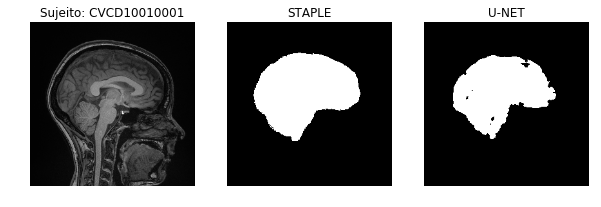

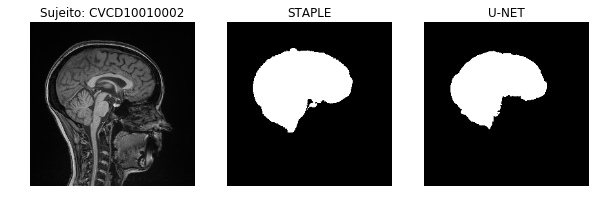

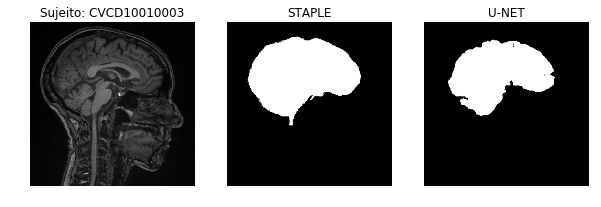

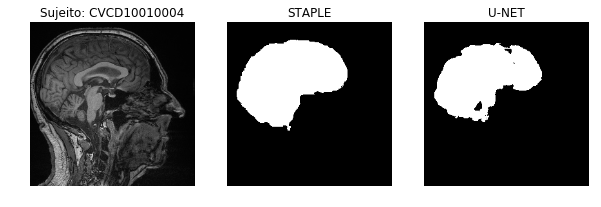

In [43]:
def plot_examples(test_image, mask_image, pred_image, name):
    
    plt.figure(figsize=(10, 15))
    plt.subplot(131)
    plt.imshow(test_image,cmap='gray')
    plt.title('Sujeito: ' + name)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask_image,cmap='gray')
    plt.title('STAPLE')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(pred_image,cmap='gray')
    plt.title('U-NET')
    plt.axis('off')
    plt.show

if __name__ == '__main__':
    
    pred_imgs_names = np.sort(glob.glob(os.path.join(out,pred_image+'/*')))

    for img_name in pred_imgs_names:
        
        name = img_name.split('/')[-1].split('-')[0]
        test_image = cv2.imread(os.path.join(out,test_mid_samples+'/' + name +'.tif')
                                , cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.imread(os.path.join(out,test_mid_samples+'/' + name +'_staple.tif')
                                , cv2.IMREAD_GRAYSCALE)
        pred_image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        plot_examples(test_image.T[::-1], mask_image.T[::-1], pred_image.T[::-1], name)